Karolina Tatarczyk

Project is written in Google Colaboratory.

# Transfer Learning
This project in an introduce to transfer learning techniques. The checklist below shows the steps necessary to finish the project.
- **Prepare a dataset**. The dataset shall be desined for image classification, and be organized to work with keras.applications (training, validation and test data should be in different folders. Images from one class should be in one subfolder). 
- **Select the network**. Select the network you want to work with. In the original code `Xception` network is selected.
- **Complete functions**. Complete missing code in the following functions
    - `add_new_last_layer` - adds an output layer to model. You may also add some layers in between. If so, remember to unfreeze these layers in `setup_to_transfer_learn` function
    - `setup_to_transfer_learn` - Freezes all layers but the last one and compiles the model
    - `setup_to_finetune` - Freezes the first not_trainable layers, and unfreezes the rest
    - `train_generator` - Creates a generator feed with train dataset. You should add data augmentation to it
- **Perform training**. Perform model trainig slowly unfreezeng the layers as long as you do not observe overfitting. In case of overfitting get back to previous model.
- **Test your model on real images**. Write a code that tests your model on real images. You should display an image, a real class of an image, the class selected by the model, and the probabilities assined by the model to all the classes.

In [ ]:
import os
import sys
import glob

import numpy as np
import pickle

import matplotlib.pyplot as plt

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam

import tensorflow as tf
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Run if you are using google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run to see how to access your google drive
!ls "/content/drive/MyDrive/LMAD/TransferLearning/data"  

checkpoints  manual  test  train  valid


In [ ]:
# If you have more than 1 GPU and you want to train on the first one only
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Arguments:
        base_model: keras model (without a top layer)
        nb_classes: number of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add the last layer and ((optionally) a dense layer
    predictions=Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model



def setup_to_transfer_learn(model, args):
    """Freezes all layers but the last one and compiles the model"""
    
    # TODO: Set all the layers but last one to not trainable.
    for layer in model.layers[:-1]:
      layer.trainable=False


    model.layers[-1].trainable=True
    opt = Nadam(lr=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def setup_to_finetune(model, args, not_trainable):
    """Freezes the first not_trainable layers, and unfreezes the rest
    Arguments:
        model: keras model
        not_trainable: number of not trainable layers
    """
    
    #Set the layers [0:not_trainable] to not trainable. Set the layers [not_trainable:] to trainable
    for layer in model.layers[0:not_trainable]:
      layer.trainable=False
    for layer in model.layers[not_trainable:]:
      layer.trainable=True  

    opt = Nadam(lr=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
def trainable_params(model, output_format = 'en_US'):
    """Computes the number of trainable parameters in the model.
    Args:
        model: keras model
        output_format: (default: 'en_US')
            'int'   - number of trainable parameters (12345)
            'en_US' - number of trainable parameters formated to comma separated str ('12,235')
    """    
    
    def nr_to_string(number, separator = ','):
        """
        Changes numbers to string.
        """
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    # And the real trainable_params function
    
    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret


### Plot results

In [ ]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }  
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1
    
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)    
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)
    
    ax2 = fig.add_subplot(122)    
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    #ax2.legend(loc='upper left');
    ax2.grid(True)
        
    plt.show()    


def process_and_display(history, old_history = None):
    new_history = unpack_history(history, old_history)
    plot_history(new_history)
    return new_history
    
    

### Hyperparameters

In [ ]:
class Args():
    def __init__(self):
        
        self.im_width, self.im_height = 299, 299 #fixed size for Xception
        self.lr = 0.001
        self.batch_size = 60
        
        local_folder = '/content/drive/MyDrive/LMAD/TransferLearning/data'
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')
            
args = Args()


### Prepare global variables

In [ ]:
nb_train_samples = get_nb_files(args.train_dir)
classes = glob.glob(args.train_dir + "/*")
classes = [x.split('/')[-1] for x in classes]
classes.sort()
nb_classes = len(classes)
nb_valid_samples = get_nb_files(args.valid_dir)

train_steps = int(nb_train_samples / args.batch_size)
valid_steps = int (nb_valid_samples / args.batch_size)

print ('Train dataset contains {} samples ({} steps / epoch)'.format(nb_train_samples, train_steps))
print ('Valid dataset contains {} samples ({} steps / epoch)'.format(nb_valid_samples, valid_steps))
print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))


Train dataset contains 660 samples (11 steps / epoch)
Valid dataset contains 120 samples (2 steps / epoch)
Dataset contains 3 classes (['mickey', 'minion', 'pumba']).


In [ ]:
nb_classes

3

### Generators

In [ ]:
# add data augmentation to the generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,

    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.14,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    args.train_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

validation_generator = test_datagen.flow_from_directory(
    args.valid_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

test_generator = test_datagen.flow_from_directory(
    args.test_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size
)

Found 625 images belonging to 3 classes.
Found 117 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


### Model

In [ ]:
model = Xception(weights='imagenet', include_top=False)
model = add_new_last_layer(model, nb_classes)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

## Training

### TODO: Perform training (transfer learning and fine tuning) to get the best results you can.


### Transfer learning

In [ ]:
setup_to_transfer_learn(model, args)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 15,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/15
11/11 [==============================] - 28s 2s/step - loss: 0.9409 - accuracy: 0.6080 - val_loss: 0.8038 - val_accuracy: 0.7436
Epoch 2/15
11/11 [==============================] - 23s 2s/step - loss: 0.6162 - accuracy: 0.8528 - val_loss: 0.5991 - val_accuracy: 0.8205
Epoch 3/15
11/11 [==============================] - 23s 2s/step - loss: 0.4414 - accuracy: 0.9104 - val_loss: 0.4961 - val_accuracy: 0.8376
Epoch 4/15
11/11 [==============================] - 23s 2s/step - loss: 0.3362 - accuracy: 0.9424 - val_loss: 0.4247 - val_accuracy: 0.8632
Epoch 5/15
11/11 [==============================] - 23s 2s/step - loss: 0.2819 - accuracy: 0.9488 - val_loss: 0.3774 - val_accuracy: 0.8889
Epoch 6/15
11/11 [==============================] - 23s 2s/step - loss: 0.2528 - accuracy: 0.9456 - val_loss: 0.3467 - val_accuracy: 0.8803
Epoch 7/15
11/11 [==============================] - 23s 2s/step - loss: 0.2129 - accuracy: 0.9552 - val_loss: 0.3248 - val_accuracy: 0.8974
Epoch 8/15
11/11 [==

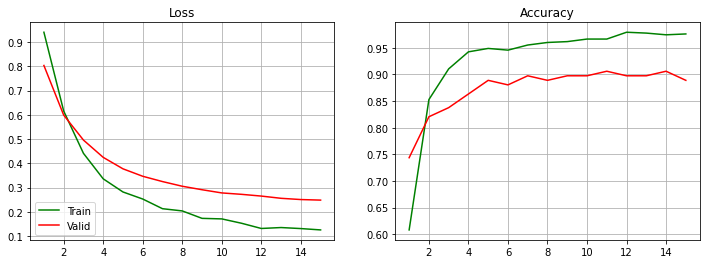

In [ ]:
tl_history = process_and_display(history)
model.save_weights('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/transfer_learning')

### Fine tuning

In [ ]:
model.layers[126].get_config()['name']

'block14_sepconv1'

In [ ]:
setup_to_finetune(model, args, not_trainable=126)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/2


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 29s 2s/step - loss: 0.2968 - accuracy: 0.9088 - val_loss: 0.1848 - val_accuracy: 0.9316
Epoch 2/2
11/11 [==============================] - 24s 2s/step - loss: 0.0465 - accuracy: 0.9824 - val_loss: 0.1434 - val_accuracy: 0.9573


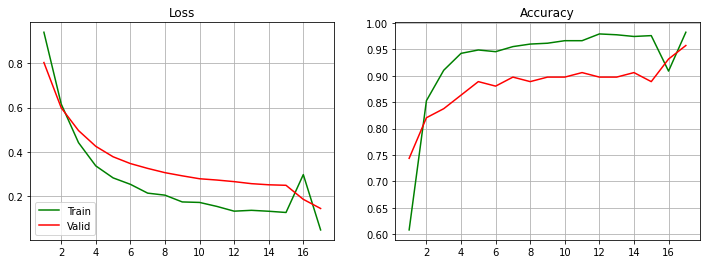

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/fine_tuning_126')

**You should continue unfreezeng the layers and training the model until the model overfits. Feel free to add as many code cells as you wish**.

In [ ]:
model.layers[117].get_config()['name']

'block13_sepconv1'

In [ ]:
setup_to_finetune(model, args, not_trainable=117)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/2
 6/11 [===============>..............] - ETA: 9s - loss: 0.0452 - accuracy: 0.9889 

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 29s 2s/step - loss: 0.0523 - accuracy: 0.9856 - val_loss: 0.1418 - val_accuracy: 0.9402
Epoch 2/2
11/11 [==============================] - 24s 2s/step - loss: 0.0223 - accuracy: 0.9936 - val_loss: 0.3525 - val_accuracy: 0.9487


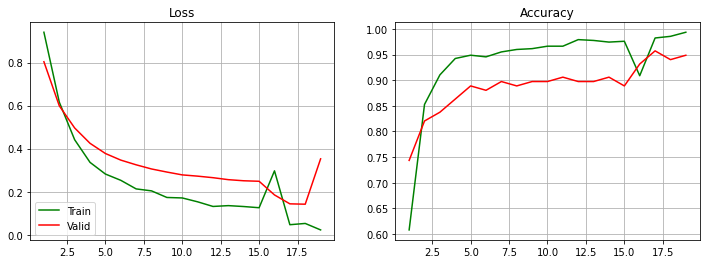

In [ ]:
ft117_history = process_and_display(history, ft126_history)
model.save_weights('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/fine_tuning_117')


In [ ]:
model.layers[110].get_config()['name']

'block12_sepconv2'

In [ ]:
setup_to_finetune(model, args, not_trainable=110)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/2
 9/11 [=======================>......] - ETA: 4s - loss: 0.0361 - accuracy: 0.9907

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 31s 2s/step - loss: 0.0317 - accuracy: 0.9920 - val_loss: 0.7701 - val_accuracy: 0.8803
Epoch 2/2
11/11 [==============================] - 24s 2s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.5797 - val_accuracy: 0.9060


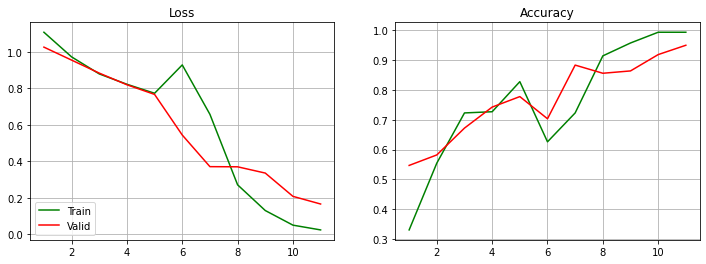

In [ ]:
ft110_history = process_and_display(history, ft117_history)
model.save_weights('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/fine_tuning_110')


In [ ]:
model.layers[100].get_config()['name']

'block11_sepconv2'

In [ ]:

setup_to_finetune(model, args, not_trainable=100)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/2
2/2 [==============================] - 24s 14s/step - loss: 0.0783 - accuracy: 0.9766 - val_loss: 0.2058 - val_accuracy: 0.9453
Epoch 2/2
2/2 [==============================] - 13s 8s/step - loss: 0.0133 - accuracy: 0.9928 - val_loss: 1.8308 - val_accuracy: 0.6367


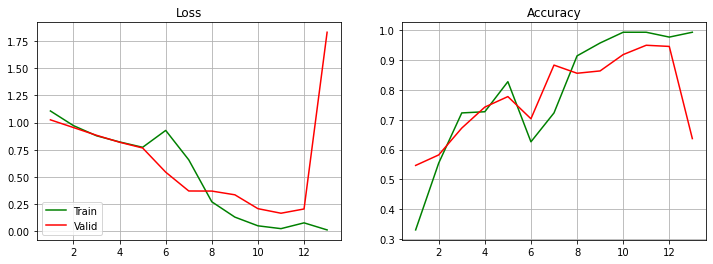

In [ ]:
ft100_history = process_and_display(history, ft110_history)
model.save_weights('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/fine_tuning_100')

In [ ]:
model.layers[93].get_config()['name']

'block10_sepconv3'

In [ ]:
setup_to_finetune(model, args, not_trainable=93)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/2
2/2 [==============================] - 22s 11s/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.9805
Epoch 2/2
2/2 [==============================] - 15s 10s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9805


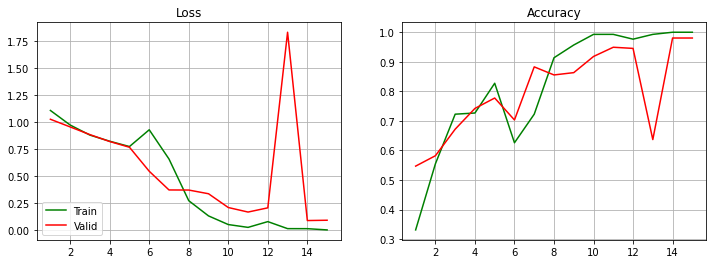

In [ ]:
ft93_history = process_and_display(history, ft100_history)
model.save_weights('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/fine_tuning_93')

# Save the final model

In [ ]:
model.load_weights('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/fine_tuning_126')
model.save('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/final')

# TEST SCORES

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/LMAD/TransferLearning/data/checkpoints/final')

In [ ]:
nb_test_samples = get_nb_files(args.test_dir)
test_steps = int (nb_test_samples / args.batch_size)
model.evaluate(test_generator, steps=test_steps)

2/2 [==============================] - 16s 14s/step - loss: 0.0454 - accuracy: 0.9903


[0.04539855942130089, 0.9902912378311157]

# TO DO
Show examples how your model works with real images. 
Try to display:
- An image
- Real class of an image
- Estimated class of an image
- Probabilities

In [ ]:
def prepareImg(path_name):
  path = "/content/drive/MyDrive/LMAD/TransferLearning/data/manual/"
  file = path + path_name

  img = tf.keras.preprocessing.image.load_img(file, target_size=(299,299))
  img=tf.keras.preprocessing.image.img_to_array(img)
  return img


def checkPrediction(classes, predictions):
  mainPredictionIndex = predictions.index(max(predictions))
  mainPrediction = classes[mainPredictionIndex]
 


def PredPlot(file, model, classes):
  img = prepareImg(file)

  fig = plt.figure(figsize=(30, 6))
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)
  ax1.imshow(img/255.)
  ax1.tick_params(labelleft=False,labelbottom=False, left=False, bottom=False)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  pred = model.predict(img)
  pred = pred.tolist()
  title = checkPrediction(classes, pred[0])

  #draw results
  fig.suptitle(title)
  for i in range(len(classes)):
    plt.bar(classes[i],
            pred[0][i],
            color='lightcoral')
    plt.text(i,pred[0][i], s="{:.2%}".format(pred[0][i]))
  plt.title('Prediction')
  plt.show()

1/1 [==============================] - 0s 22ms/step


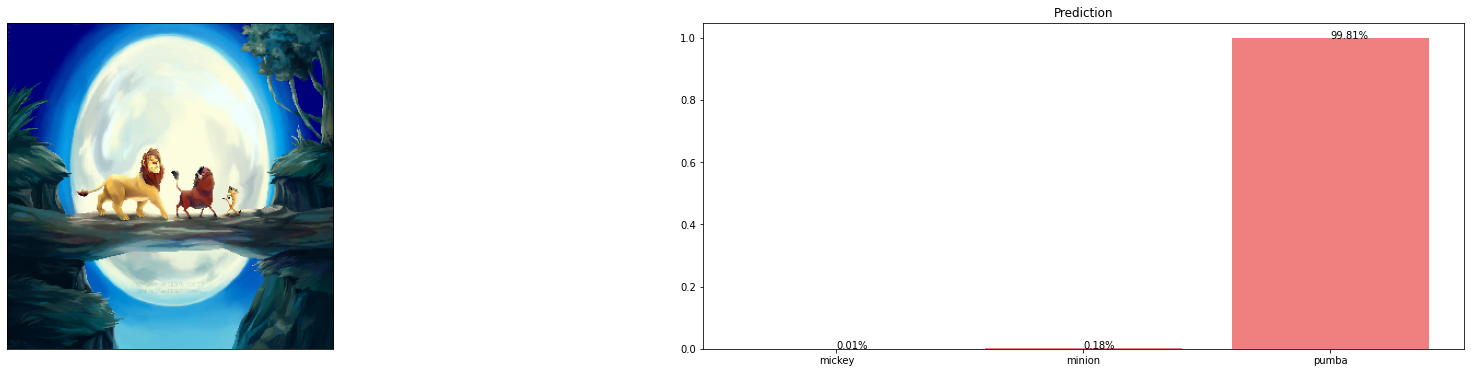

1/1 [==============================] - 0s 21ms/step


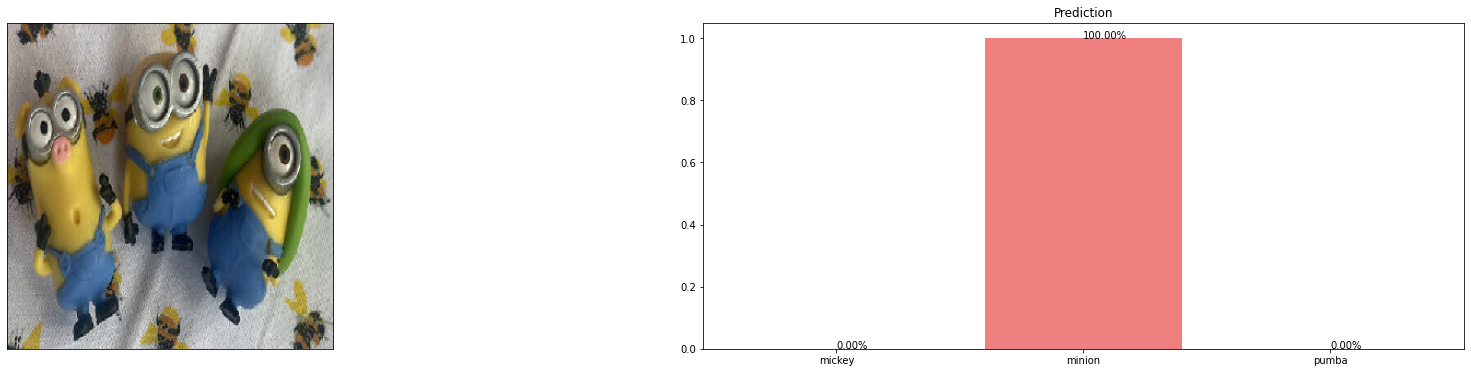

1/1 [==============================] - 0s 23ms/step


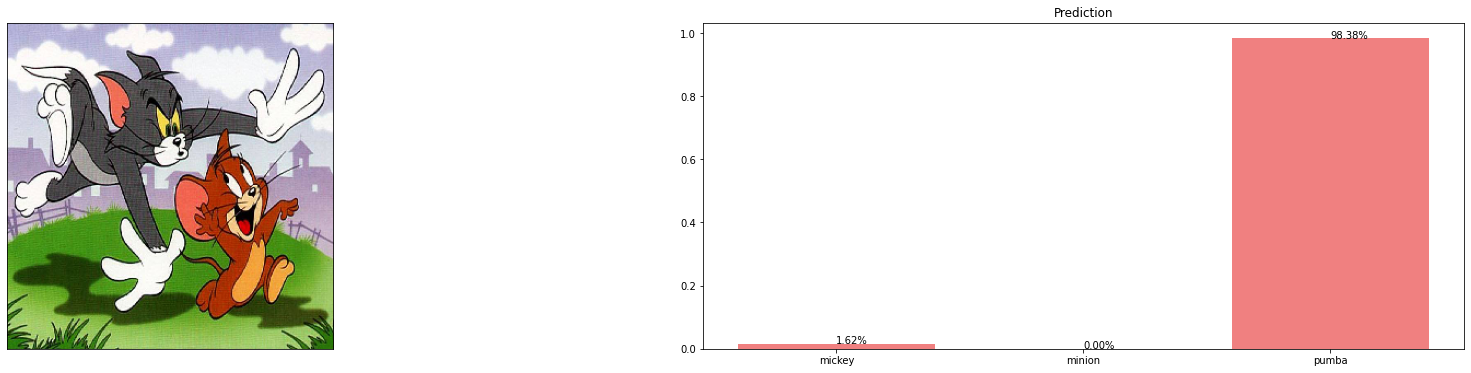

1/1 [==============================] - 0s 27ms/step


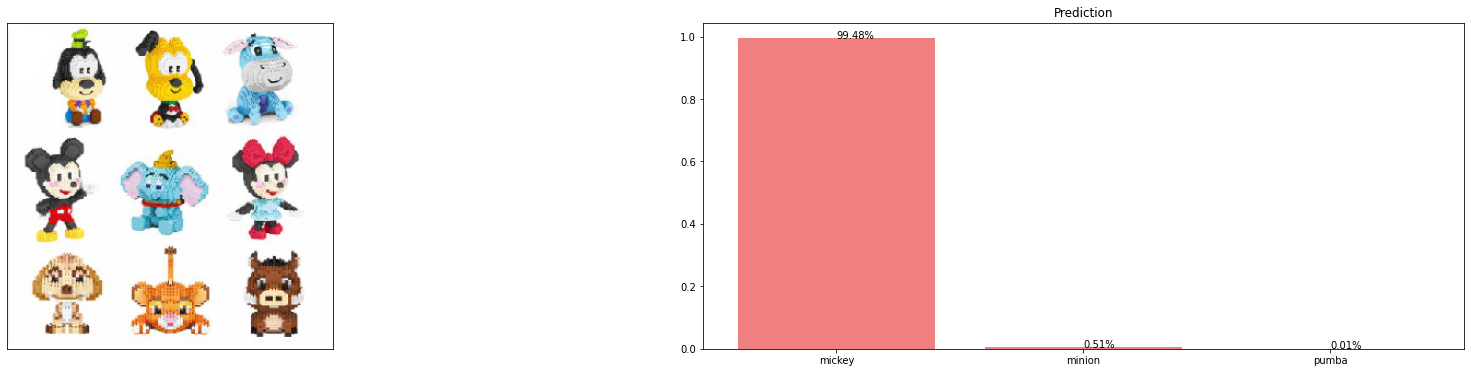

1/1 [==============================] - 0s 32ms/step


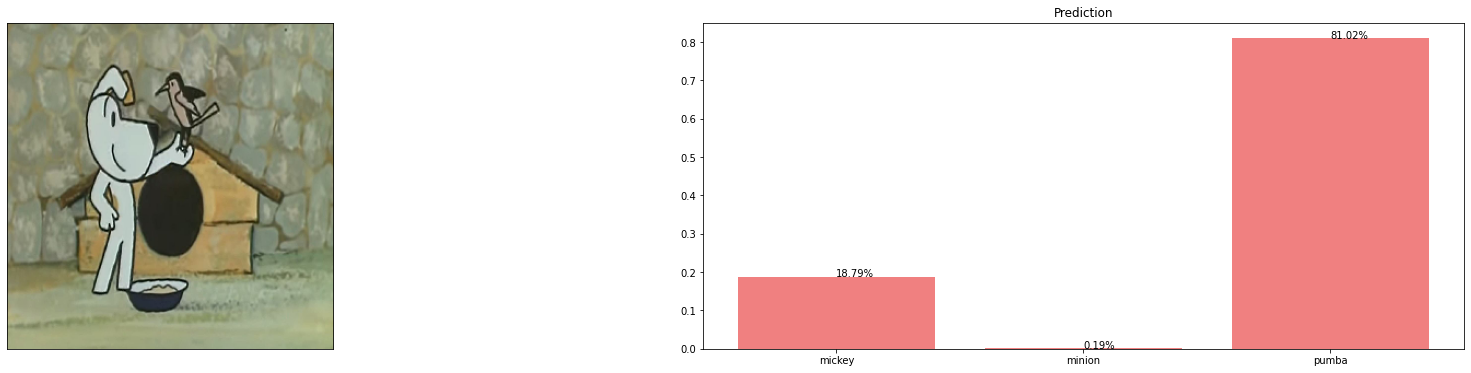

1/1 [==============================] - 0s 22ms/step


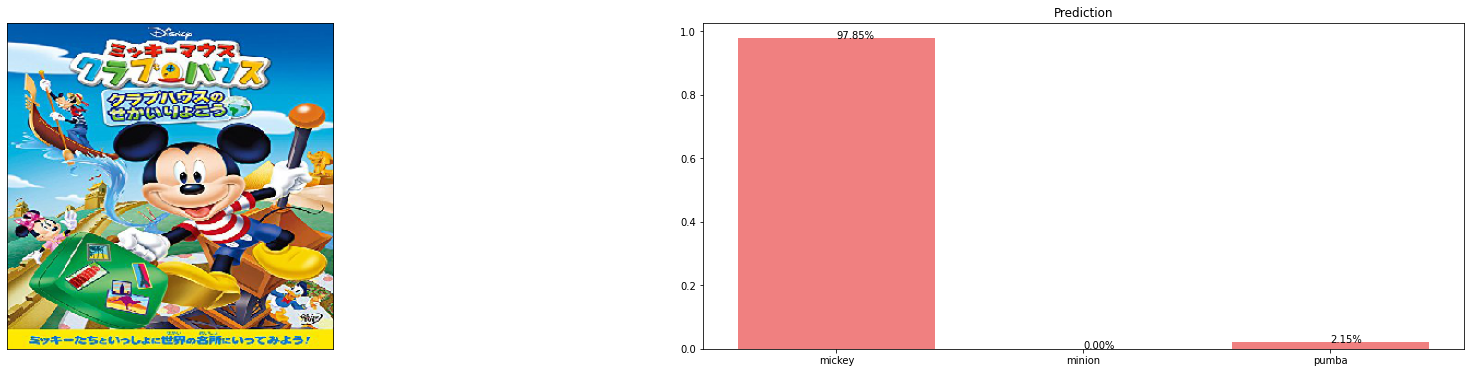

1/1 [==============================] - 0s 23ms/step


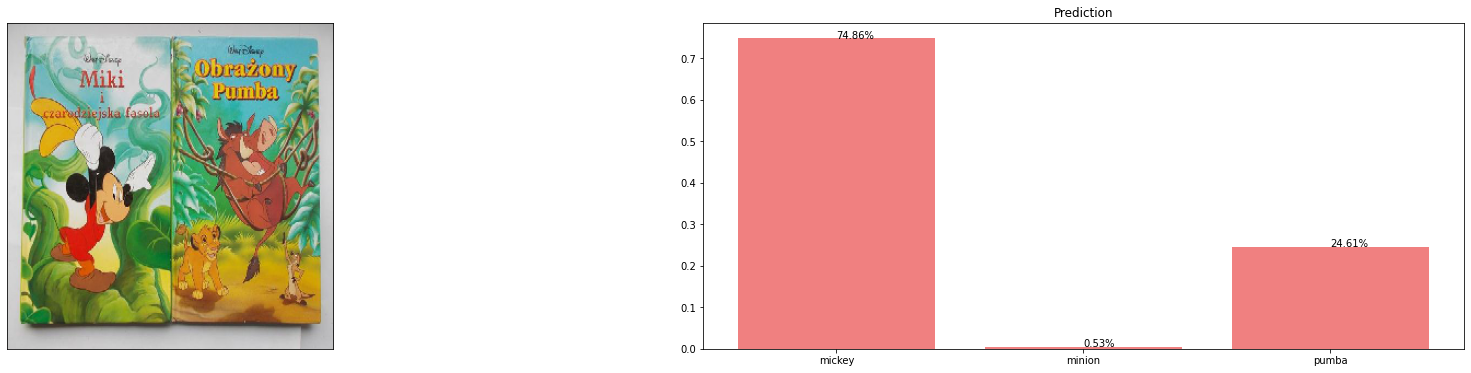

1/1 [==============================] - 0s 20ms/step


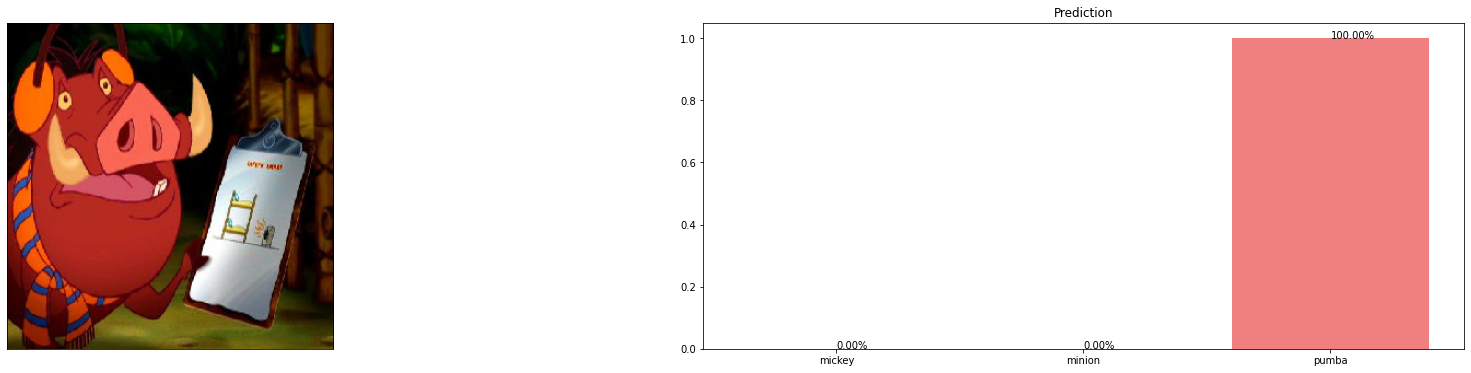

1/1 [==============================] - 0s 20ms/step


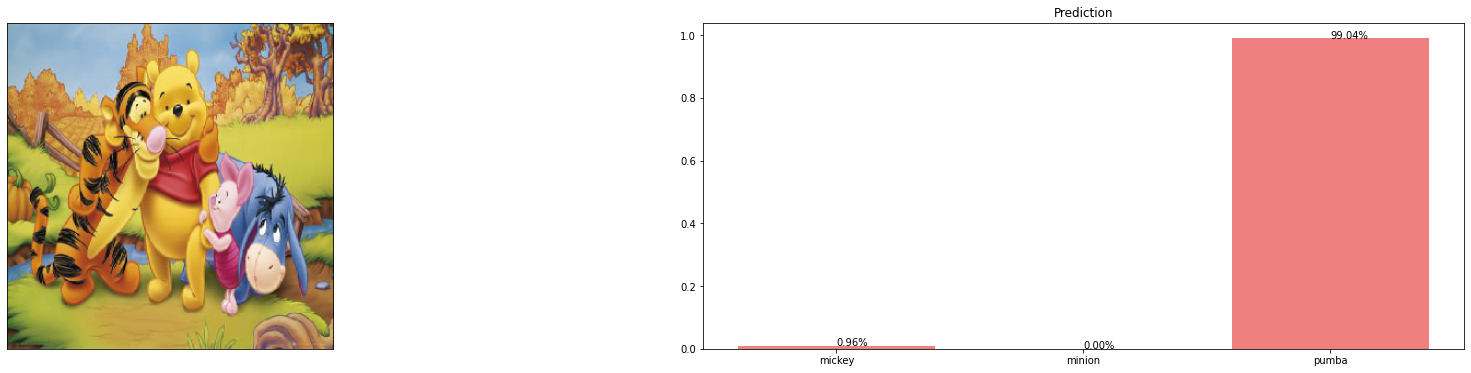

1/1 [==============================] - 0s 20ms/step


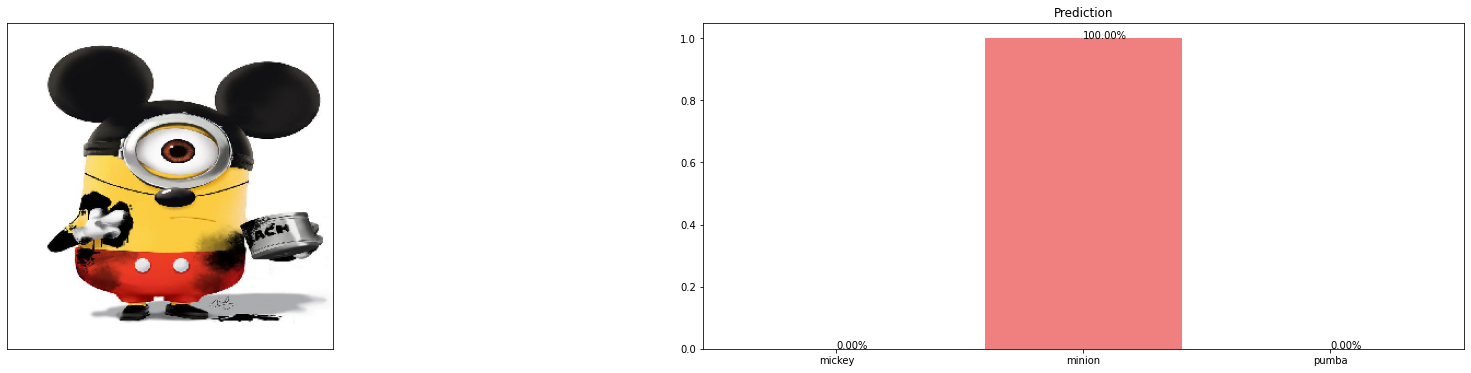

In [ ]:

for i in range(10):
  PredPlot('{}.jpg'.format(i+1), model, classes)

In [ ]:
# table = [ '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg','9.jpg' ,'10.jpg'
#                  ]
# for i in range(len(table)):
#   PredPlot(table[i], model, classes)
